In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt

## Preparing Data
First I import the data using Pandas. I had some issues importing using numpy as some of the columns had text as input. Next I only includes the rows that has either 'cp' or 'im' in the eight column. Then I drop the first column, as it only contain text and is not useful for the testing. 

After this I change all occurences of 'im' and 'cp' into one's and zeros, and makes them float. Lastly I vizualize them as an array of objects to be similar as in the example.

In [3]:
dataset_unfiltered = pd.read_csv("../../Datasets/ecoli.data", sep='\\s+', header=None)
dataset_filtered = dataset_unfiltered[dataset_unfiltered.iloc[:, 8].isin(['cp', 'im'])]
dataset_filtered = dataset_filtered.drop(dataset_filtered.columns[0], axis=1)
dataset_filtered.iloc[:, 7] = dataset_filtered.iloc[:, 7].replace(['im', 'cp'], ['1', '0'])
dataset_filtered = dataset_filtered.astype(float)
dataset = dataset_filtered.values

print(dataset)

## Increasing the dataset and shuffeling.
np.random.seed(7)
np.random.shuffle(dataset)

##Setting a splitratio, which is how much of the data will be used for training, and how much is used for testing.
splitratio = 0.8

# split into input (X) and output (Y) variables
X_train = torch.Tensor(dataset[:int(len(dataset)*splitratio),0:7])
X_test = torch.Tensor(dataset[int(len(dataset)*splitratio):,0:7])
Y_train = torch.Tensor(dataset[:int(len(dataset)*splitratio),7])
Y_test = torch.Tensor(dataset[int(len(dataset)*splitratio):,7])

[[0.49 0.29 0.48 ... 0.24 0.35 0.  ]
 [0.07 0.4  0.48 ... 0.35 0.44 0.  ]
 [0.56 0.4  0.48 ... 0.37 0.46 0.  ]
 ...
 [0.61 0.47 0.48 ... 0.8  0.32 1.  ]
 [0.63 0.75 0.48 ... 0.73 0.66 1.  ]
 [0.71 0.52 0.48 ... 1.   0.99 1.  ]]


## Defining the Neural Network Class
Starting with 7 inputs, which is connected to three Neurons in the first hidden layer. This is again connected to a single output, which will calculate the network's prediction.

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7,3)
        self.fc2 = nn.Linear(3,1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze() ## Squeezing to match the shape of the predictions and target tensors. Thanks to ChatGPT.

model = Net()
print("Model", model)
print("Parameters",[param.nelement() for param in model.parameters()])

print("Weights",[param.data for param in model.parameters()])

Model Net(
  (fc1): Linear(in_features=7, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)
Parameters [21, 3, 3, 1]
Weights [tensor([[-0.1508,  0.1186, -0.0765,  0.0546,  0.2746,  0.3230,  0.3600],
        [ 0.3308, -0.1545, -0.0418,  0.3294, -0.1628,  0.1110,  0.1536],
        [-0.1931, -0.2679,  0.0061,  0.0099,  0.0524, -0.1470,  0.2972]]), tensor([0.1659, 0.1626, 0.1016]), tensor([[ 0.2128, -0.2815,  0.3319]]), tensor([-0.5443])]


Importing torchsummary to get an overview of the state of the architecture.

In [39]:
summary(model,X_train.shape)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

## Using the dataset to train the data

### The loss function
For this implementation, the "Binary Cross Entropy Loss with Logits" function is used to measure how well the implementation works. It is a combination of Sigmoid Layer and Binary Cross Entropy Loss. 

### Optimizer
Adam is used as optimizer, and is commonly used, as the model's weights are updated during training using gradients computed during backprogogation. The learning rate is set to 0.01. This value is set after some testing. 

In [40]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Saving values for loss and accuracy
train_loss = []
test_loss = []
train_acc = []
test_acc = []

## Calculating accuracy using sigmoid to see if the value is 1 or 0
def calculate_accuracy(predictions, targets):
    predictions = torch.round(torch.sigmoid(predictions))
    correct = (predictions == targets).float().sum()
    return correct / len(targets)

for epoch in range(300):
    
    ## Training
    model.train()
    
    # Forward pass
    y_pred_train = model(X_train)
    y_pred_test = model(X_test)
    loss_train = criterion(y_pred_train, Y_train.float())
    loss_test = criterion(y_pred_test, Y_test.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    ## Evaluation mode
    model.eval() 

    # Saving loss data
    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())

    # Calculating accuracy
    acc_test = calculate_accuracy(y_pred_test, Y_test.float())
    acc_train = calculate_accuracy(y_pred_train, Y_train.float())

    # Saving accuracy data
    test_acc.append(acc_test.item())
    train_acc.append(acc_train.item())
    
    # Printing loss and accuracy every 10th
    if(epoch % 50 == 0):
        print(f'Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}, '
              f'Train Accuracy: {acc_train.item()*100:.2f}%, Test Accuracy: {acc_test.item()*100:.2f}%')

print("Final Test Accuracy:", test_acc[-1] * 100, "%")

Epoch 0, Train Loss: 0.6526, Test Loss: 0.6466, Train Accuracy: 64.77%, Test Accuracy: 65.91%
Epoch 50, Train Loss: 0.5934, Test Loss: 0.5887, Train Accuracy: 64.77%, Test Accuracy: 65.91%
Epoch 100, Train Loss: 0.4330, Test Loss: 0.4395, Train Accuracy: 90.91%, Test Accuracy: 81.82%
Epoch 150, Train Loss: 0.2882, Test Loss: 0.3018, Train Accuracy: 94.89%, Test Accuracy: 97.73%
Epoch 200, Train Loss: 0.2076, Test Loss: 0.2227, Train Accuracy: 96.02%, Test Accuracy: 97.73%
Epoch 250, Train Loss: 0.1624, Test Loss: 0.1814, Train Accuracy: 96.02%, Test Accuracy: 97.73%
Final Test Accuracy: 97.72727489471436 %


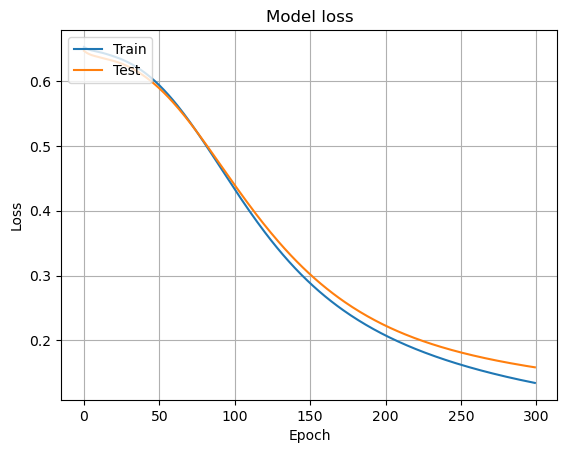

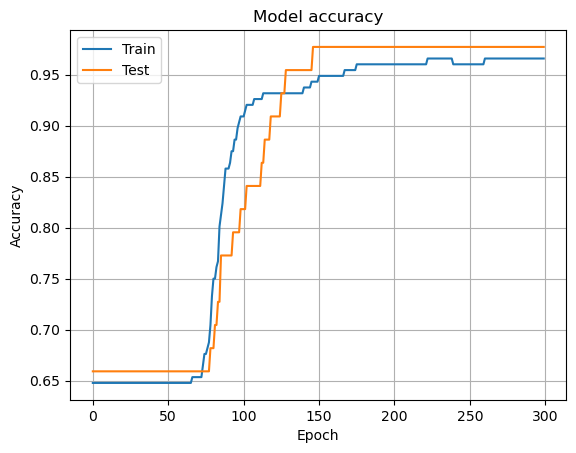

In [41]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(train_loss)
plt.plot(test_loss)
plt.grid(True)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(train_acc)
plt.plot(test_acc)
plt.grid(True)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()